# Gogle Colab Set up

Running these cells allow colab to download the repo with the code need for this notebook.

In [ ]:
!git clone https://github.com/Juanki0396/TFG

In [ ]:
import os
os.chdir("TFG")

In [ ]:
!pip install -r requirements.txt
!mkdir save_models

# Training a classifier

In this notebook we will run 3 training steps comparing the classifying capacity of a Resnet with 3 different scenarios:

1. Images with random labels
2. Images with and without added noise
3. Original images without noise and noise images treated with a CycleGan

In [1]:
import random
from typing import List

from src.data.dataset import ImageDataset, CycleGanDataset , generate_noisy_dataset, generate_cyclegan_dataset
from src.data.data_transforms import DynamicRangeScaling, RandomNoise, Resize
from src.data.image import Image
from src.models.clasifier_model import ImageClassifier
from src.models.cyclegan_model import CycleGan
from src.models.classifier_trainer import ClassifierTrainer
from src.models.cyclegan_trainer import CycleGanTrainer
from src.options.classifier_options import ClassifierOptions
from src.options.cyclegan_options import CycleGanOptions
from src.utils import load_xray_data, refactor_dataset, refactor_cyclegan_datasets, obtain_voxel_range, obtain_histogram

random.seed(12345)
STD_NOISE = 600

## 1. Images with random labels

SELECTED VOXEL RANGE: (0.0, 6859.0)


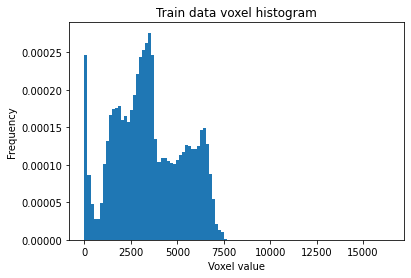

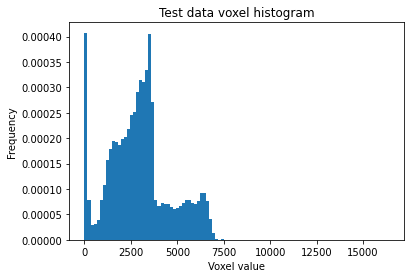

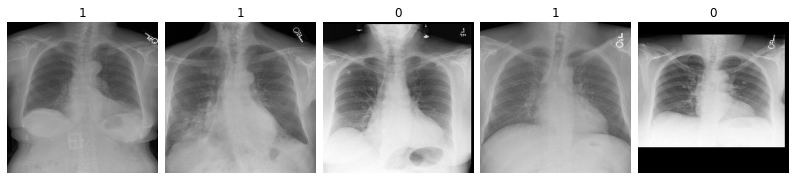

In [4]:
data = load_xray_data()
train_data, test_data = refactor_dataset(data=data, ratio_validation=0.2)

hist1 = obtain_histogram(train_data, sample_size=40, title="Train data voxel histogram")
hist2 = obtain_histogram(test_data, sample_size=40, title="Test data voxel histogram")

voxel_range = obtain_voxel_range(data=train_data, sample_size=30, extreme_percent=2)
print(f"SELECTED VOXEL RANGE: {voxel_range}")

fig = Image.create_image_grid(train_data[:5], grid_size=(14,8))

-----------------------MODEL OPTIONS------------------------
Name                     ---->            random_labels
Device                   ---->                   cuda:0
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        1
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->       BinaryCrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       10
Image_size               ---->                 (64, 64)
Num_threads              ---->                        2
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->            (0.0, 6859.0)

---------------------Training Epoch: 0----------------------
Running training batch 37/37
Training

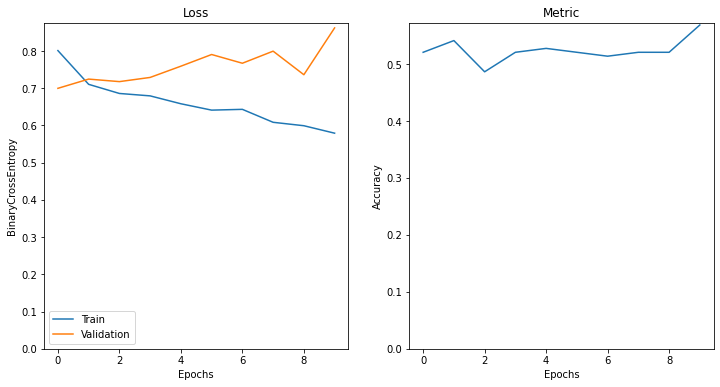

In [5]:
def randomise_labels(dataset: List[Image]) -> List[Image]:
    for image in dataset:
        image.label = random.randint(0,1)
    return dataset

# Load predefined options and modify some of them
options_parser = ClassifierOptions()
options_parser.read_parameters()
options_parser.gather_options(force=True)
options_parser.rewrite_option("name", "random_labels")
options_parser.rewrite_option("device", "cuda:0")
options_parser.rewrite_option("crop_dynamic_range", voxel_range)
options_parser.print_options()

# Crate random labels
random_train_data = randomise_labels(train_data)
random_test_data = randomise_labels(test_data)

# Create torch datasets
transforms = [
    Resize(options_parser.options.image_size),
    DynamicRangeScaling(options_parser.options.model_dynamic_range, options_parser.options.crop_dynamic_range)
]
train_dataset = ImageDataset(random_train_data, transforms= transforms)
test_dataset = ImageDataset(random_test_data, transforms= transforms)

# Create models and trainer
model = ImageClassifier(options_parser)
trainer = ClassifierTrainer(model)
trainer.set_dataloaders(train_dataset, test_dataset)

# Train model
trainer.train_model()
loss_fig = trainer.plot_losses()


## 2. Images with and without added noise

SELECTED VOXEL RANGE: (-244.20212807805908, 7013.0)


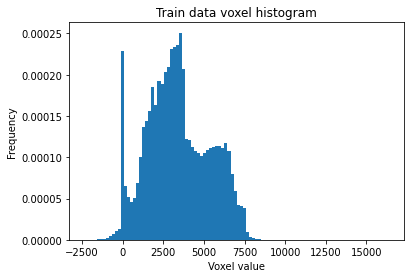

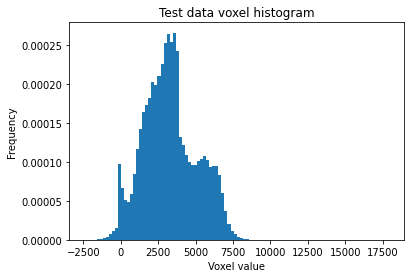

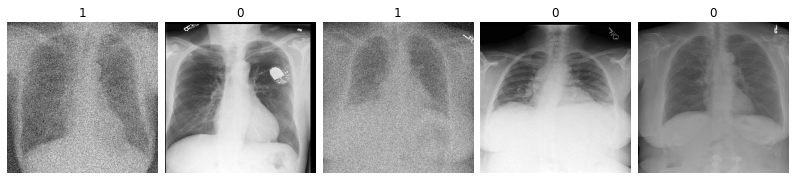

In [2]:


data = load_xray_data()
train_data, test_data = refactor_dataset(data=data, ratio_validation=0.2)
train_noisy_data = generate_noisy_dataset(train_data, STD_NOISE)
test_noisy_data = generate_noisy_dataset(test_data, STD_NOISE)

hist1 = obtain_histogram(train_noisy_data, sample_size=40, title="Train data voxel histogram")
hist2 = obtain_histogram(test_noisy_data, sample_size=40, title="Test data voxel histogram")

voxel_range = obtain_voxel_range(data=train_noisy_data, sample_size=40, extreme_percent=2)
print(f"SELECTED VOXEL RANGE: {voxel_range}")

fig = Image.create_image_grid(train_noisy_data[:5], grid_size=(14,8))

-----------------------MODEL OPTIONS------------------------
Name                     ---->              Noisy_xrays
Device                   ---->                   cuda:0
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        1
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->       BinaryCrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       10
Image_size               ---->                 (64, 64)
Num_threads              ---->                        2
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->(-244.20212807805908, 7013.0)

---------------------Training Epoch: 0----------------------
Running training batch 37/37
Trai

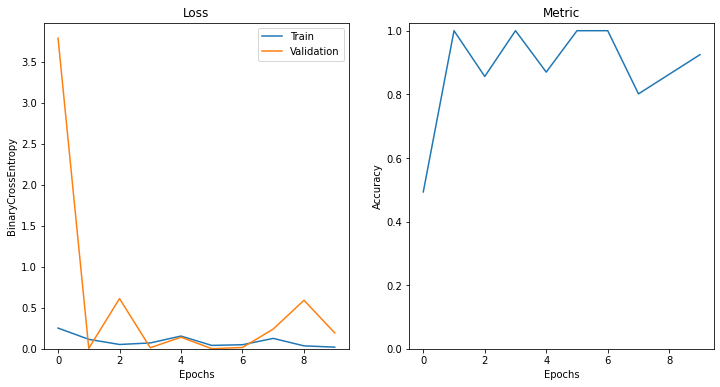

In [3]:
# Load predefined options and modify some of them
options_parser = ClassifierOptions()
options_parser.read_parameters()
options_parser.gather_options(force=True)
options_parser.rewrite_option("name", "Noisy_xrays")
options_parser.rewrite_option("device", "cuda:0")
options_parser.rewrite_option("crop_dynamic_range", voxel_range)
options_parser.print_options()

# Create torch datasets
transforms = [
    Resize(options_parser.options.image_size),
    DynamicRangeScaling(options_parser.options.model_dynamic_range, options_parser.options.crop_dynamic_range)
]
train_noisy_dataset = ImageDataset(train_noisy_data, transforms=transforms)
test_noisy_dataset = ImageDataset(test_noisy_data, transforms=transforms)

# Create models and trainer
model = ImageClassifier(options_parser)
trainer = ClassifierTrainer(model)
trainer.set_dataloaders(train_noisy_dataset, test_noisy_dataset)

# Train model
trainer.train_model()
fig = trainer.plot_losses()

## 3. Real and CycleGan Images

SELECTED VOXEL RANGE: (0.0, 7025.0)


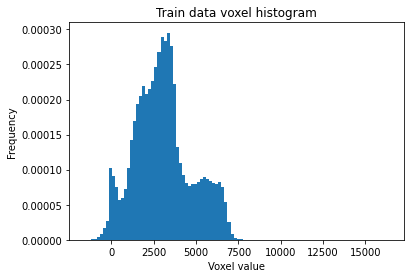

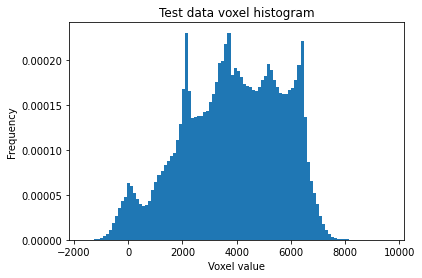

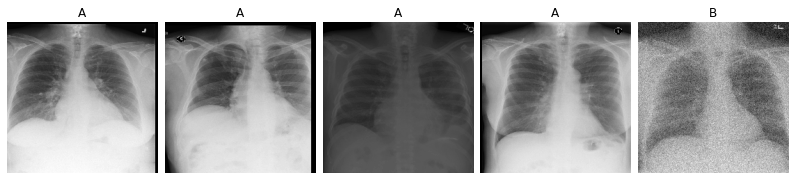

In [2]:

data = load_xray_data()
train_data, test_data = refactor_cyclegan_datasets(data, n_validation=10)
train_cyclegan_data = generate_cyclegan_dataset(train_data, STD_NOISE)
test_cyclegan_data = generate_cyclegan_dataset(test_data, STD_NOISE)

hist1 = obtain_histogram(train_cyclegan_data, sample_size=40, title="Train data voxel histogram")
hist2 = obtain_histogram(test_cyclegan_data, sample_size=40, title="Test data voxel histogram")

voxel_range = obtain_voxel_range(data=train_cyclegan_data, sample_size=40, extreme_percent=2)
print(f"SELECTED VOXEL RANGE: {voxel_range}")

fig = Image.create_image_grid(train_cyclegan_data[:5], grid_size=(14,8))

In [4]:
#Load Options
options_parser = CycleGanOptions()
options_parser.read_parameters()
options_parser.gather_options(force=True)
options_parser.rewrite_option("name", "CycleGan_xrays")
options_parser.rewrite_option("device", "cuda:0")
options_parser.rewrite_option("crop_dynamic_range", voxel_range)
options_parser.print_options()

# Create torch datasets
transforms = [
    Resize(options_parser.options.image_size),
    DynamicRangeScaling(options_parser.options.model_dynamic_range, options_parser.options.crop_dynamic_range)
]
train_cyclegan_dataset = CycleGanDataset(train_cyclegan_data, transforms=transforms)
test_cyclegan_dataset = CycleGanDataset(train_cyclegan_data, transforms=transforms)

# Create model and trainer
model = CycleGan(options_parser)
trainer = CycleGanTrainer(model)
trainer.set_dataloaders(train_cyclegan_dataset, test_cyclegan_dataset)

# Train the model
trainer.train_model()
fig = trainer.plot_training_losses()


-----------------------MODEL OPTIONS------------------------
Name                     ---->           CycleGan_xrays
Device                   ---->                   cuda:0
Saved_models_dir         ---->           ./saved_models
Net_g                    ---->                   resnet
Net_d                    ---->                    patch
Learning_rate            ---->                   0.0002
Beta                     ---->                     0.99
Epochs_constant          ---->                      100
Epochs_decay             ---->                      100
Lr_constant              ---->                    False
Image_size               ---->                 (64, 64)
Num_threads              ---->                        2
Batch_size               ---->                        1
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->            (0.0, 7025.0)

--------------------------EPOCH 0---------------------------
Running training batch 86/360

KeyboardInterrupt: 